In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import  AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer, TextClassificationPipeline, pipeline

/Users/selinameyer/Documents/GitHub/Gradio_Chatbot/gradio_bot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#emp_pilot = pd.read_csv("../../../Empathy-Mental-Health-master/dataset/translated_transcripts_classified.csv")
#pilot_info = pd.read_csv("../../../Chatbot_components/Logs/Pilot_tests/All_Micha_transkripts.csv", sep=";")

epitome = pd.read_csv("User_Study_output.csv")
empintent = pd.read_csv("classified_turns.csv")
info = pd.read_csv("../Main_Study/turns_with_context.csv")

In [8]:
epitome["condition"] = info["condition"]
epitome["chat_id"] = info["chat_id"]
epitome["turn_id"] = info["turn_id"]

In [7]:
epitome.to_csv("epitome_context.csv")

In [9]:
epitome.dropna(inplace=True)

In [ ]:
#emp_pilot["empathy_score"] = emp_pilot["ER_label"] + emp_pilot["IP_label"] + emp_pilot["EX_label"]

In [10]:
epitome_melted = epitome.melt(id_vars=["id", "condition", "turn_id", "chat_id", "seeker_post", "response_post"], value_vars=["ER_label", "IP_label", "EX_label"], value_name="value", var_name="label")
epitome_sel = epitome[(epitome["turn_id"] >= 4) & (epitome["turn_id"] <= 10)]
epitome_melted_grouped = epitome_sel.melt(id_vars=["condition","chat_id"], value_vars=["ER_label", "IP_label", "EX_label"], value_name="value", var_name="label")


In [11]:
result = epitome_melted_grouped.groupby(['chat_id', 'label', 'condition'])["value"].value_counts().unstack(fill_value=0).reset_index()
result.head()

value,chat_id,label,condition,0,1,2
0,1,ER_label,framework,7,0,0
1,1,EX_label,framework,1,0,6
2,1,IP_label,framework,7,0,0
3,2,ER_label,no_system,1,5,1
4,2,EX_label,no_system,6,0,1


In [12]:
result_melted = pd.melt(result, id_vars=["label", "condition"], value_vars=[0, 1, 2], var_name='strength', value_name='count')
result_melted["label"].replace({"ER_label": "Emotional Reactions", "IP_label": "Interpretations", 
                                "EX_label": "Explorations"}, inplace=True)
result_melted["condition"].replace({"framework": "MI-adapted", "no_system": "GPT-4"}, inplace=True)
result_melted.head()

,label,condition,strength,count
0,Emotional Reactions,MI-adapted,0,7
1,Explorations,MI-adapted,0,1
2,Interpretations,MI-adapted,0,7
3,Emotional Reactions,GPT-4,0,1
4,Explorations,GPT-4,0,6


/Users/selinameyer/Documents/GitHub/Gradio_Chatbot/gradio_bot/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


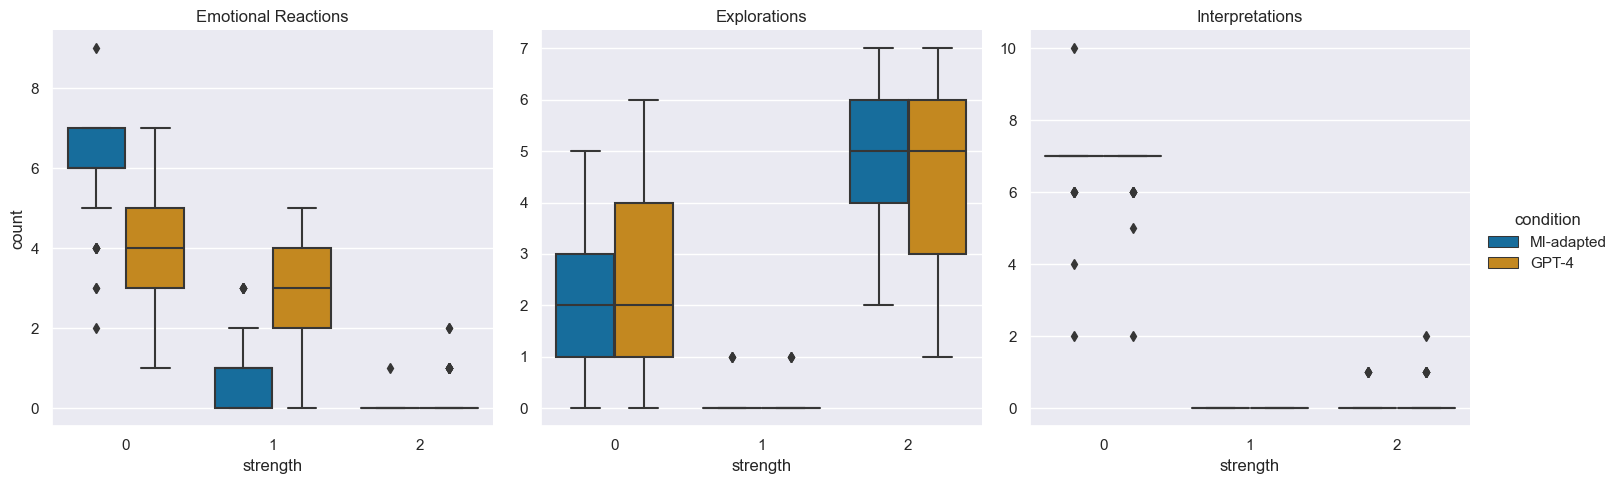

In [78]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_palette("colorblind")
ax = sns.catplot(data=result_melted, x="strength", y="count", hue="condition", col="label", kind="box", sharey=False)
ax.set_titles("{col_name}")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xticks(rotation=90)
#plt.show()

In [20]:
result_melted.groupby(["label", "category", "condition"])["count"].describe()

count      mean       std  min  25%  \
label               category condition                                         
Emotional Reactions 0        GPT-4        80.0  3.975000  1.377716  1.0  3.0   
                             MI-adapted   85.0  6.094118  1.181439  2.0  6.0   
                    1        GPT-4        80.0  2.775000  1.330984  0.0  2.0   
                             MI-adapted   85.0  0.823529  0.965802  0.0  0.0   
                    2        GPT-4        80.0  0.187500  0.452664  0.0  0.0   
                             MI-adapted   85.0  0.011765  0.108465  0.0  0.0   
Explorations        0        GPT-4        80.0  2.612500  1.562971  0.0  1.0   
                             MI-adapted   85.0  1.941176  1.312513  0.0  1.0   
                    1        GPT-4        80.0  0.037500  0.191182  0.0  0.0   
                             MI-adapted   85.0  0.035294  0.185617  0.0  0.0   
                    2        GPT-4        80.0  4.287500  1.568630  1.0  3.0   
                             MI-adapted   85.0  4.952941  1.280865  2.0  4.0   
Interpretations     0        GPT-4        80.0  6.825000  0.651677  2.0  7.0   
                             MI-adapted   85.0  6.870588  0.752587  2.0  7.0   
                    1        GPT-4        80.0  0.000000  0.000000  0.0  0.0   
                             MI-adapted   85.0  0.000000  0.000000  0.0  0.0   
                    2        GPT-4        80.0  0.112500  0.355562  0.0  0.0   
                             MI-adapted   85.0  0.058824  0.236691  0.0  0.0   

                                         50%  75%   max  
label               category condition                   
Emotional Reactions 0        GPT-4       4.0  5.0   7.0  
                             MI-adapted  6.0  7.0   9.0  
                    1        GPT-4       3.0  4.0   5.0  
                             MI-adapted  1.0  1.0   3.0  
                    2        GPT-4       0.0  0.0   2.0  
                             MI-adapted  0.0  0.0   1.0  
Explorations        0        GPT-4       2.0  4.0   6.0  
                             MI-adapted  2.0  3.0   5.0  
                    1        GPT-4       0.0  0.0   1.0  
                             MI-adapted  0.0  0.0   1.0  
                    2        GPT-4       5.0  6.0   7.0  
                             MI-adapted  5.0  6.0   7.0  
Interpretations     0        GPT-4       7.0  7.0   7.0  
                             MI-adapted  7.0  7.0  10.0  
                    1        GPT-4       0.0  0.0   0.0  
                             MI-adapted  0.0  0.0   0.0  
                    2        GPT-4       0.0  0.0   2.0  
                             MI-adapted  0.0  0.0   1.0

In [13]:
rel_turns = epitome_melted[(epitome_melted["turn_id"] >= 4) & (epitome_melted["turn_id"] <= 10)]
rel_turns.head()

,id,condition,turn_id,chat_id,seeker_post,response_post,label,value
3,3,framework,4,62,4,A 4. That sounds like you're not too confident...,ER_label,0
4,4,framework,5,62,I'm still not sure if the time is good.,You're not sure if the time is good. Is there ...,ER_label,0
5,5,framework,6,62,I'm tied up for work.,You are very tense in your job. Do you remembe...,ER_label,0
6,6,framework,7,62,"Yes, there was that time.",So there was a time when you managed to feed y...,ER_label,0
7,7,framework,8,62,I was more motivated.,"So you've been more motivated, and you have th...",ER_label,0


In [22]:
rel_turns.groupby(["condition", "label"])["value"].describe()

count      mean       std  min  25%  50%  75%  max
condition label                                                       
framework ER_label  589.0  0.122241  0.332990  0.0  0.0  0.0  0.0  2.0
          EX_label  589.0  1.434635  0.898538  0.0  0.0  2.0  2.0  2.0
          IP_label  589.0  0.016978  0.183643  0.0  0.0  0.0  0.0  2.0
no_system ER_label  555.0  0.454054  0.549989  0.0  0.0  0.0  1.0  2.0
          EX_label  555.0  1.241441  0.968499  0.0  0.0  2.0  2.0  2.0
          IP_label  555.0  0.032432  0.252840  0.0  0.0  0.0  0.0  2.0

/Users/selinameyer/Documents/GitHub/Gradio_Chatbot/gradio_bot/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


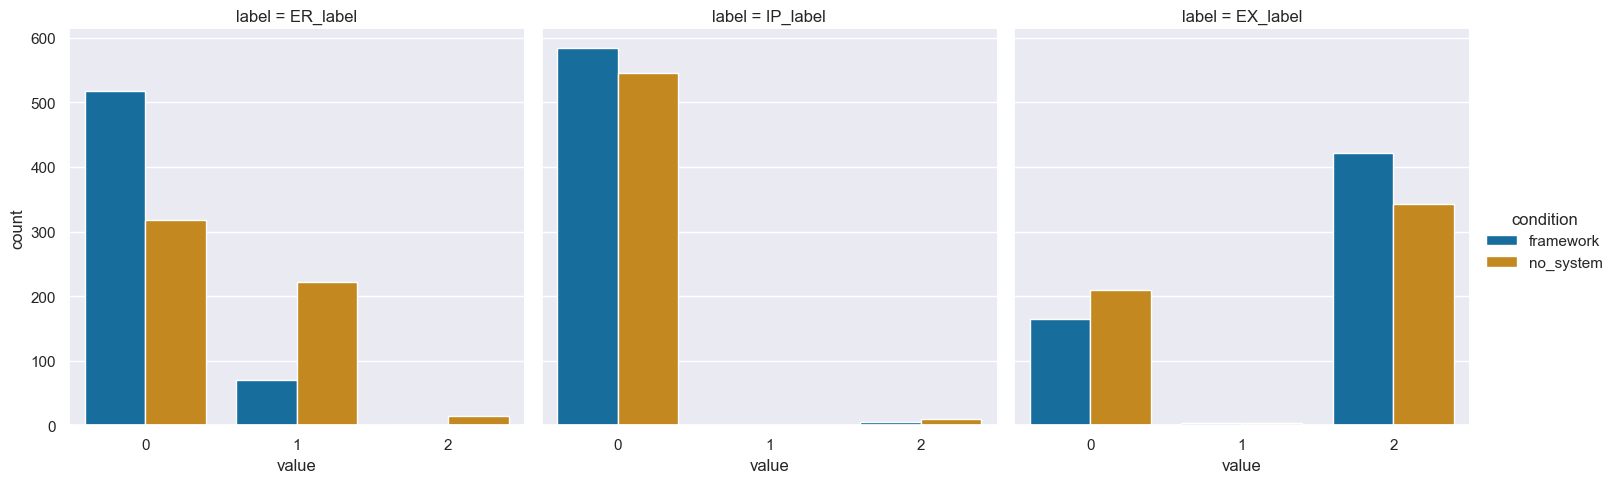

In [23]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_palette("colorblind")
ax = sns.catplot(data=rel_turns, x="value", col="label", hue="condition", kind="count")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xticks(rotation=90)
plt.show()

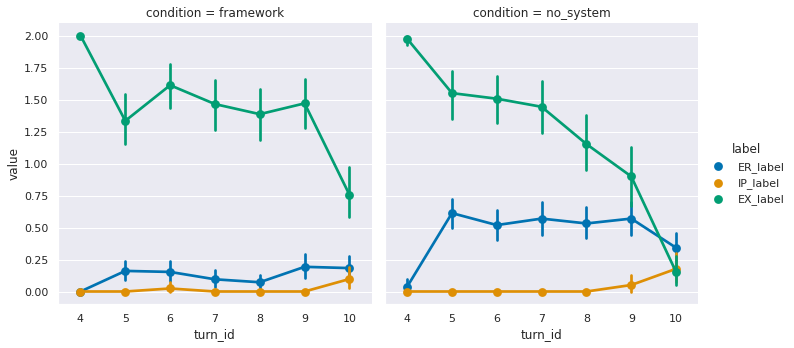

In [36]:
sns.set(rc={"figure.figsize":(20, 7)})
sns.set_palette("colorblind")
ax = sns.catplot(data=rel_turns, x="turn_id", y="value", hue="label", col="condition", kind="point")
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xticks(rotation=90)
plt.show()

In [14]:
### Pre-train Classifier first

tokenizer = AutoTokenizer.from_pretrained("../EmpatheticIntents/EmpatheticClassifier/bert_model")
model = AutoModelForSequenceClassification.from_pretrained("../EmpatheticIntents/EmpatheticClassifier/bert_model", local_files_only=True).cuda()
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)

In [15]:
rel_turns.head()

,id,condition,turn_id,seeker_post,response_post,label,value
3,3,framework,4,4,A 4. That sounds like you're not too confident...,ER_label,0
4,4,framework,5,I'm still not sure if the time is good.,You're not sure if the time is good. Is there ...,ER_label,0
5,5,framework,6,I'm tied up for work.,You are very tense in your job. Do you remembe...,ER_label,0
6,6,framework,7,"Yes, there was that time.",So there was a time when you managed to feed y...,ER_label,0
7,7,framework,8,I was more motivated.,"So you've been more motivated, and you have th...",ER_label,0


In [16]:
def get_label(output):
    label = output[0]['label']
    score = output[0]['score']
    return label, score

In [ ]:
pred_label = []
pred_score = []

for index, row in tqdm(rel_turns.iterrows()):
    out = pipe(row["response_post"])
    label, score = get_label(out)
    pred_label.append(label)
    pred_score.append(score)
    
rel_turns["Empathetic Intent"] = pred_label
rel_turns["Empintent_score"] = pred_score

#agent_dials.to_csv("classified_agent_dials")

In [18]:
rel_turns.replace({"LABEL_1":"agreeing", "LABEL_2":"acknowledging",
                     "LABEL_3":"encouraging", "LABEL_4":"consoling",
                     "LABEL_5":"sympathizing", "LABEL_6":"suggesting",
                     "LABEL_7":"questioning", "LABEL_8": "wishing",
                     "LABEL_0":"neutral"}, inplace=True)

/tmp/ipykernel_51/4168298319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_turns.replace({"LABEL_1":"agreeing", "LABEL_2":"acknowledging",


In [3]:
rel_turns = pd.read_csv("classified_turns.csv").drop_duplicates(subset=["id"])
len(rel_turns)

1144

In [25]:
rel_turns.head()

,Unnamed: 0,id,condition,turn_id,seeker_post,response_post,label,value,Empathetic Intent,Empintent_score
0,3,3,framework,4,4,A 4. That sounds like you're not too confident...,ER_label,0,questioning,0.999811
1,4,4,framework,5,I'm still not sure if the time is good.,You're not sure if the time is good. Is there ...,ER_label,0,questioning,0.999855
2,5,5,framework,6,I'm tied up for work.,You are very tense in your job. Do you remembe...,ER_label,0,questioning,0.999867
3,6,6,framework,7,"Yes, there was that time.",So there was a time when you managed to feed y...,ER_label,0,neutral,0.999603
4,7,7,framework,8,I was more motivated.,"So you've been more motivated, and you have th...",ER_label,0,neutral,0.838621


In [26]:
len(rel_turns)

1144

In [59]:
rel_turns_grouped = rel_turns.groupby(["condition"])["Empathetic Intent"].value_counts().unstack(fill_value=0).reset_index()
#rel_turns_grouped_melted = pd.melt(rel_turns_grouped, ["Empathetic Intent", "turn_id"], ["framework", "no_system"])

In [60]:
rel_turns_grouped

Empathetic Intent,condition,acknowledging,agreeing,consoling,neutral,questioning,suggesting,sympathizing,wishing
0,framework,32,42,7,40,452,13,1,2
1,no_system,38,58,6,33,354,31,31,4


In [61]:
rel_turns_grouped["condition"].replace({"framework": "MI-adapted", "no_system": "GPT-4"}, inplace=True)
rel_turns_grouped.set_index(['condition'], inplace=True)


rel_turns_percentage = rel_turns_grouped.div(rel_turns_grouped.sum(axis=1), axis=0) * 100

In [62]:
rel_turns_percentage

Empathetic Intent,acknowledging,agreeing,consoling,neutral,questioning,suggesting,sympathizing,wishing
condition,,,,,,,,
MI-adapted,5.432937,7.13073,1.188455,6.791171,76.740238,2.207131,0.169779,0.339559
GPT-4,6.846847,10.45045,1.081081,5.945946,63.783784,5.585586,5.585586,0.720721


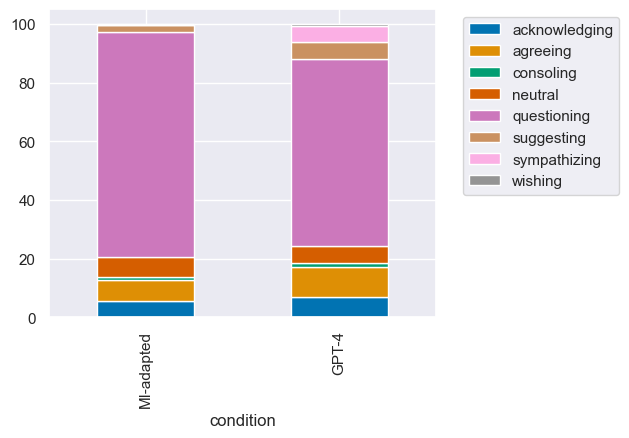

In [75]:
ax = rel_turns_percentage.plot(kind='bar', stacked=True, figsize=(5,4))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [40]:
rel_turns_grouped_melted = pd.melt(rel_turns_grouped, id_vars=["condition"], 
                                   value_vars=["acknowledging", "agreeing", "consoling", "neutral", "questioning", "suggesting", "sympathizing", "wishing"], var_name='Empathetic Intent', value_name='count')
rel_turns_grouped_melted.head()

,condition,Empathetic Intent,count
0,framework,acknowledging,32
1,no_system,acknowledging,38
2,framework,agreeing,42
3,no_system,agreeing,58
4,framework,consoling,7


In [ ]:
rel_turns_grouped_melted.plot(kind="bar", x="condition", y="percentage", )

<Axes: xlabel='Empathetic Intent', ylabel='count'>

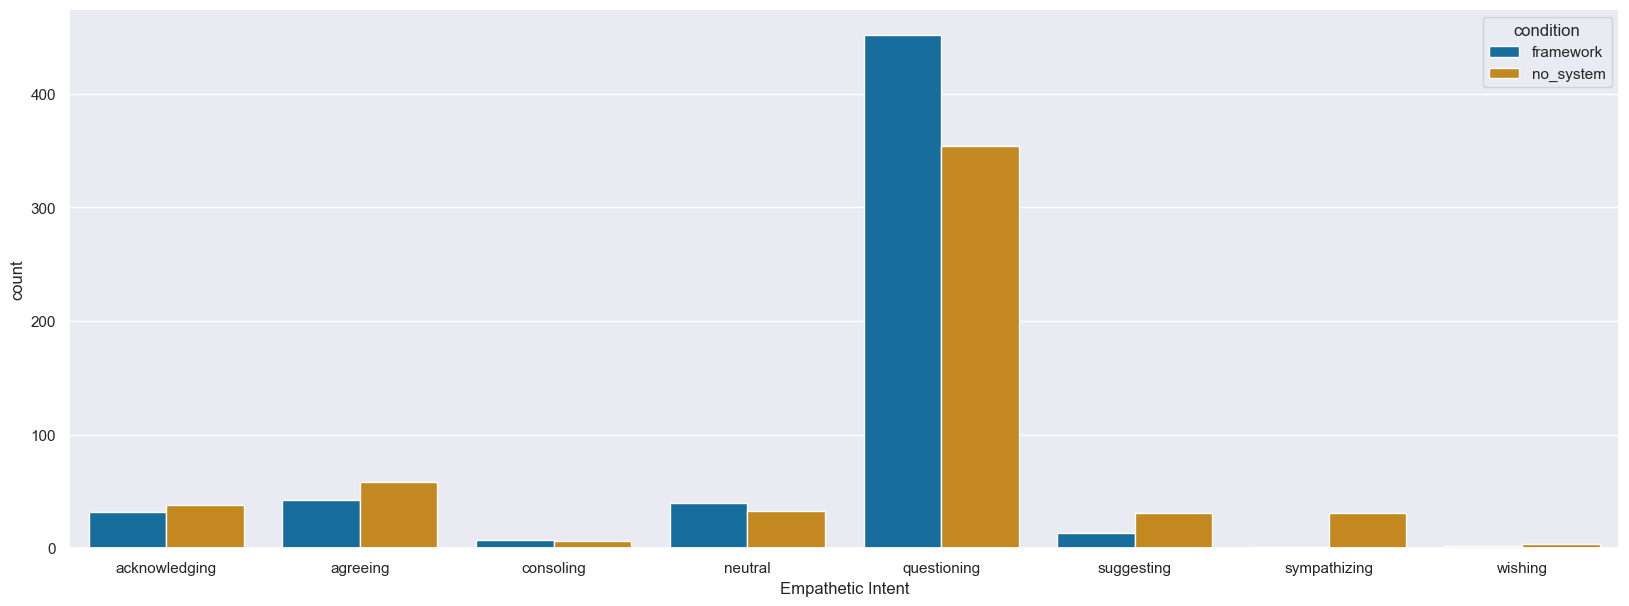

In [104]:
sns.barplot(data=rel_turns_grouped_melted,
            x="Empathetic Intent", y="count", hue="condition")

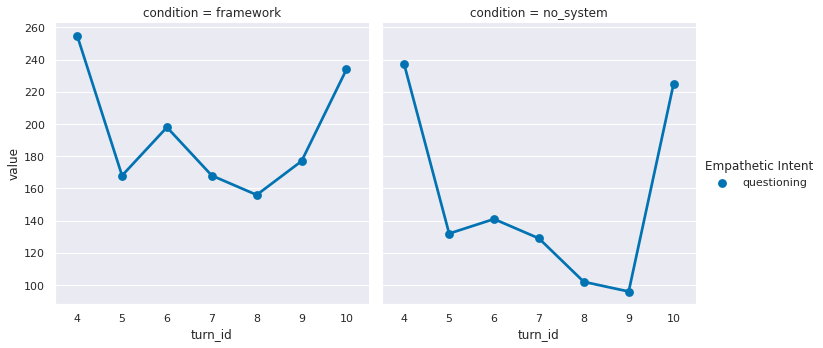

In [28]:
sns.catplot(data=rel_turns_grouped_melted[rel_turns_grouped_melted["Empathetic Intent"] == "questioning"],
            x="turn_id", y="value", hue="Empathetic Intent", 
            col="condition", kind="point")

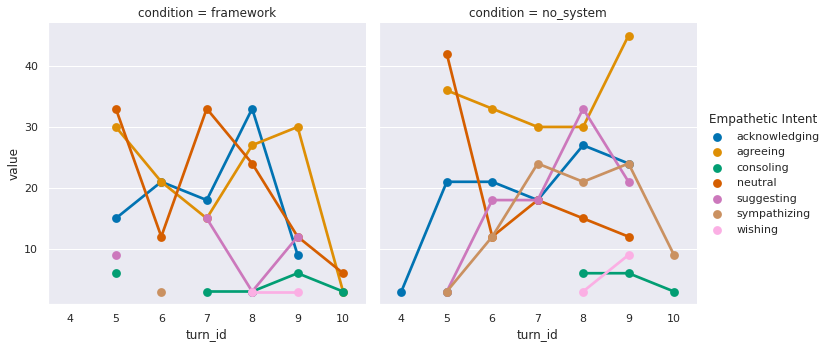

In [31]:
sns.catplot(data=rel_turns_grouped_melted[rel_turns_grouped_melted["Empathetic Intent"] != "questioning"],
            x="turn_id", y="value", hue="Empathetic Intent", 
            col="condition", kind="point")

<Axes: xlabel='Empathetic Intent', ylabel='count'>

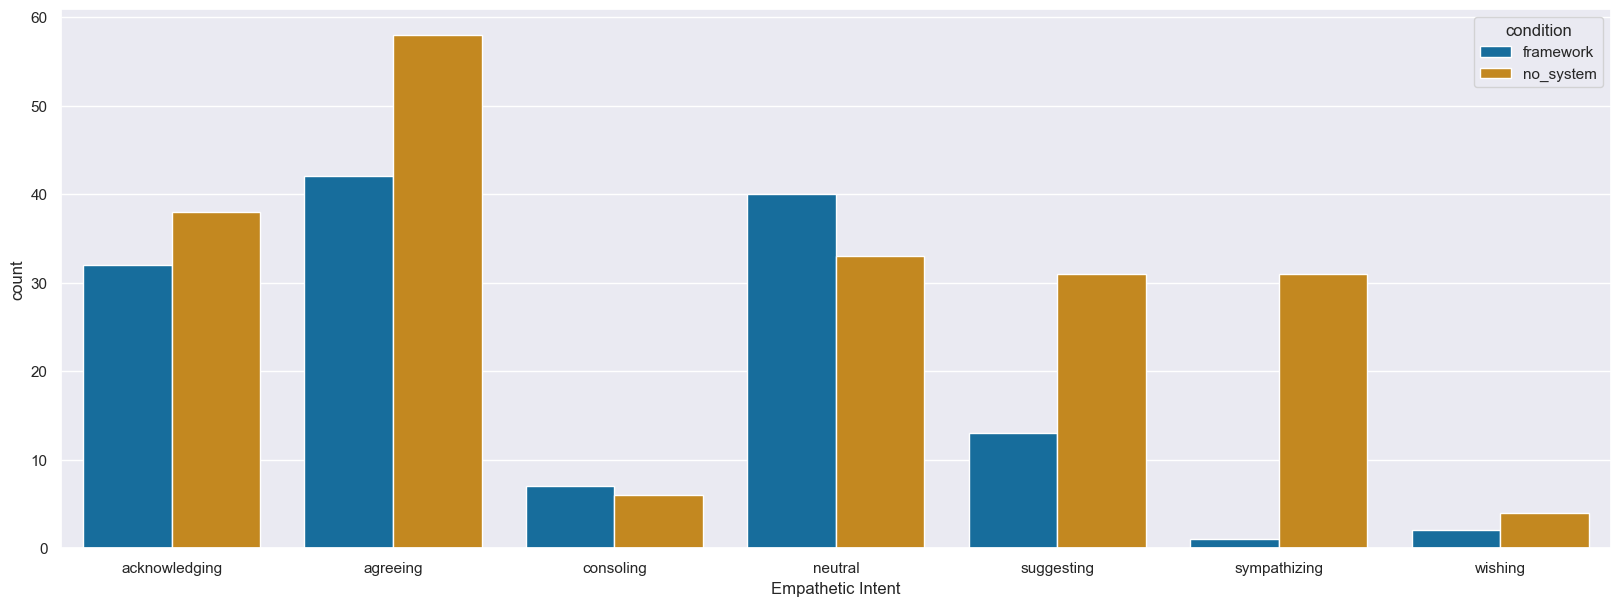

In [105]:
sns.barplot(data=rel_turns_grouped_melted[rel_turns_grouped_melted["Empathetic Intent"] != "questioning"],
            x="Empathetic Intent", y="count", hue="condition")

In [24]:
rel_turns.to_csv("classified_turns.csv")